In [1]:
# !pip install pandas_datareader

In [2]:
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas_datareader as pdr
from datetime import datetime, timedelta

In [3]:
#Get the stock
ticker = 'AAPL'
stock ="Apple"
# Time step n days, here we will use n  days historical data to predict next day closing
ts_points = 120
# train_data[0:60,0]  

today = datetime.today()
# start_date ='2016-01-01'
start_date = (today - timedelta(days=5*365) ).strftime('%Y-%m-%d')

# end_date   = today.strftime('%Y-%m-%d')
end_date = (today - timedelta(days=31) ).strftime('%Y-%m-%d')

stock_df = pdr.DataReader(ticker, data_source="yahoo", start=start_date, end=end_date)

In [4]:
# Date is an index but to be sure , let's sort
stock_df = stock_df.sort_index(ascending=True)
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-10-25,29.590000,29.327499,29.487499,29.562500,192516000.0,27.724911
2016-10-26,28.924999,28.327499,28.577499,28.897499,264536800.0,27.101248
2016-10-27,28.965000,28.525000,28.847500,28.620001,138248000.0,26.841002
2016-10-28,28.802500,28.362499,28.467501,28.430000,151446800.0,26.662806
2016-10-31,28.557501,28.299999,28.412500,28.385000,105677600.0,26.620600
...,...,...,...,...,...,...
2021-09-17,148.820007,145.759995,148.820007,146.059998,129868800.0,146.059998
2021-09-20,144.839996,141.270004,143.800003,142.940002,123478900.0,142.940002
2021-09-21,144.600006,142.779999,143.929993,143.429993,75834000.0,143.429993


In [5]:
# check for nulls
stock_df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [6]:
# Get shape
stock_df.shape

(1237, 6)

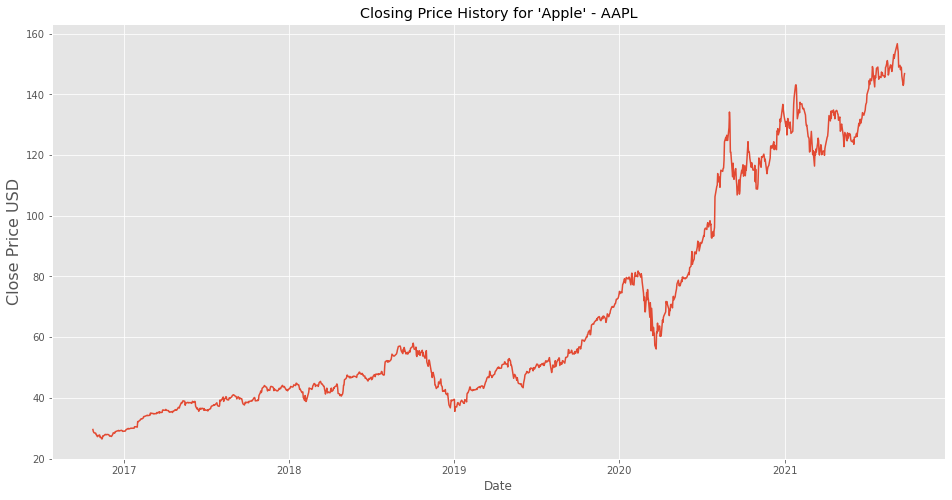

In [7]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(stock_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

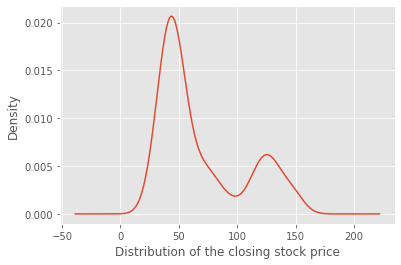

In [8]:
stock_df['Close'].plot.density()
plt.xlabel('Distribution of the closing stock price')
plt.show()

In [9]:
# DF with only close
TSdata_df = stock_df.filter(['Close'])
TSdata_df


,Close
Date,
2016-10-25,29.562500
2016-10-26,28.897499
2016-10-27,28.620001
2016-10-28,28.430000
2016-10-31,28.385000
...,...
2021-09-17,146.059998
2021-09-20,142.940002
2021-09-21,143.429993


In [10]:
TSdata_arr = TSdata_df.values # this creates an array of Close Price
TSdata_arr

array([[ 29.5625    ],
       [ 28.89749908],
       [ 28.62000084],
       ...,
       [143.42999268],
       [145.8500061 ],
       [146.83000183]])

In [11]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

# ADF Test
result = adfuller(TSdata_arr, autolag='AIC')

print('ADF Statistic: %f' % result[0])

print('p-value: %f' % result[1])

print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: 0.347607
p-value: 0.979426
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


In [12]:
df2 = TSdata_df['Close'].diff().dropna().to_frame()
df2

,Close
Date,
2016-10-26,-0.665001
2016-10-27,-0.277498
2016-10-28,-0.190001
2016-10-31,-0.045000
2016-11-01,-0.512501
...,...
2021-09-17,-2.729996
2021-09-20,-3.119995
2021-09-21,0.489990


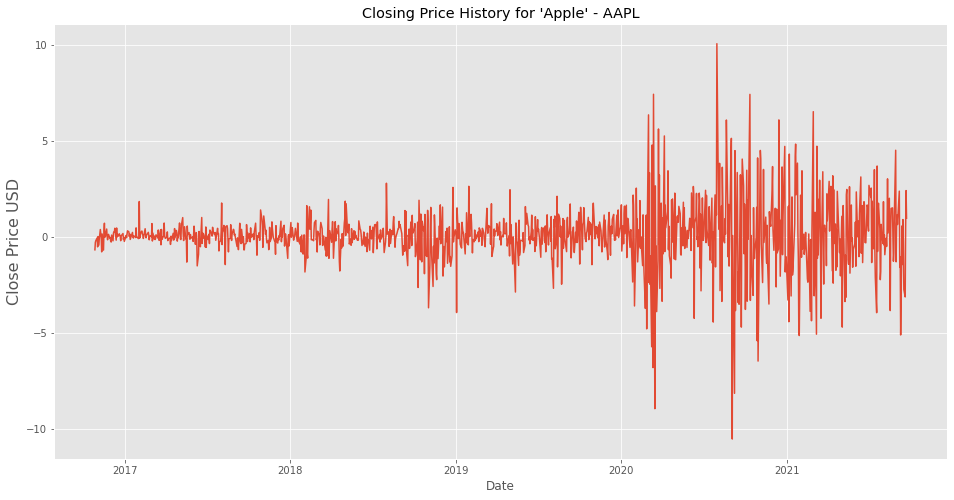

In [13]:
# Visualize closing price history
plt.figure(figsize=(16,8))
plt.title (f"Closing Price History for '{stock}' - {ticker}")
plt.plot(df2['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD', fontsize=16)
plt.show()

In [14]:
# TSdata_arr = df2.filter(['Close']).values
# TSdata_arr

In [15]:
# Scale the Data
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(TSdata_arr)
# scaled_data

In [16]:
training_data_len = math.ceil(len(TSdata_arr) * 0.75)
training_data_len

928

In [17]:
# Created scaled training dataset
train_data = scaled_data[0:training_data_len]
train_data.shape

(928, 1)

In [18]:
# Split
X_train = []
y_train = []

for i in range(ts_points, len(train_data)):
    X_train.append(train_data[i-ts_points:i,0])
    y_train.append(train_data[i,0])
    # if i <= ts_points+3:
    #     print(X_train)
    #     print(y_train)
    #     print()


In [19]:
# convert X_train and y_train to numpy arrays for LSTM
X_train, y_train = np.array(X_train), np.array(y_train)

In [20]:
print (X_train.shape)
print (y_train.shape)

(808, 120)
(808,)


In [21]:
# LSTM network expects a 3D input (No_of_Samples, number of time steps, and number of features) no_of_features = 1 (Close)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(808, 120, 1)

In [22]:
training_data_len - ts_points

808

In [23]:
# hidden_nodes = int(2/3 * (X_train.shape[1] * 1))
# print(f"The number of hidden nodes is {hidden_nodes}.")

In [24]:
# LSTM MOdel
model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(tf.keras.layers.LSTM(50, return_sequences=False))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(25))
# model.add(tf.keras.layers.Dense(1))
# model.summary()


In [25]:

# # BEST FOR TESLA#
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.summary()

# #model.fit(X_train, y_train, batch_size=64, epochs=50

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='adam', loss='mean_squared_error')
# model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size=64

os.makedirs("chk_points/", exist_ok=True)
chkpoint_path="chk_points/weights.{epoch}.hdf5"

# Create chk points
chkpt_callback = ModelCheckpoint(filepath=chkpoint_path,
                              verbose=1,
                              save_weights_only=True,
                              save_freq="epoch",
                              period=5)

# chkpoint_path = "chk_points/cp-{epoch:04d}.ckpt"
# chkpt_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=chkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*batch_size)                    

# model.save_weights(chkpoint_path.format(epoch=0))    


In [28]:
# training_data_len
# scaled_data

In [29]:
# model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_split=0.43, callbacks=[chkpt_callback])
model.fit(X_train, y_train, batch_size=64 ,epochs=32)

Epoch 1/32
13/13 [==============================] - 4s 113ms/step - loss: 0.0117
Epoch 2/32
13/13 [==============================] - 1s 115ms/step - loss: 0.0029
Epoch 3/32
13/13 [==============================] - 1s 107ms/step - loss: 0.0012
Epoch 4/32
13/13 [==============================] - 1s 108ms/step - loss: 7.9272e-04
Epoch 5/32
13/13 [==============================] - 1s 115ms/step - loss: 7.5538e-04
Epoch 6/32
13/13 [==============================] - 1s 105ms/step - loss: 5.6975e-04
Epoch 7/32
13/13 [==============================] - 1s 103ms/step - loss: 5.6462e-04
Epoch 8/32
13/13 [==============================] - 2s 167ms/step - loss: 5.0521e-04
Epoch 9/32
13/13 [==============================] - 2s 168ms/step - loss: 4.7456e-04
Epoch 10/32
13/13 [==============================] - 2s 159ms/step - loss: 4.9815e-04
Epoch 11/32
13/13 [==============================] - 2s 160ms/step - loss: 4.7956e-04
Epoch 12/32
13/13 [==============================] - 2s 164ms/step - loss: 

In [30]:
model.save('Saved_Models/Model_'+ticker+'.h5')

In [31]:
# test_data = scaled_data[training_data_len:]

# Bring in the last 'ts_points' (60 values) from training set so when X_test is used to predict , predictions have same shape as Y_test
# The for loop starts with 'ts_points' thatbmeans the resultant array will have 60 less rows
test_data = scaled_data[training_data_len-ts_points:]
# test_data[0:60,0]


In [32]:
X_test = []
y_test = TSdata_arr[training_data_len:]
for i in range(ts_points, len(test_data)):
    X_test.append(test_data[i-ts_points:i,0])


In [33]:
# convert the data to a numpy array to use it in LSTM MODEL
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1], 1))

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
# Models predicted price for X_train
predictions_tr = model.predict(X_train)
predictions_tr = scaler.inverse_transform(predictions_tr)

y_train_tr =  scaler.inverse_transform(y_train.reshape(-1,1))
rmse_tr = math.sqrt(mean_squared_error(y_train_tr, predictions_tr))
rmse_tr

1.759138898329136

In [36]:
# Models predicted price for X_test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [37]:
y_test.shape, predictions.shape

((309, 1), (309, 1))

In [38]:
# RMSE to check accuracy

rmse = math.sqrt(mean_squared_error(y_test, predictions))
rmse

4.376630397012958

In [39]:
# Plot
train = TSdata_df[:training_data_len]
actual = TSdata_df[training_data_len:]
actual['Predictions'] = predictions
actual

<ipython-input-39-bb86776ae978>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual['Predictions'] = predictions


,Close,Predictions
Date,,
2020-07-06,93.462502,91.562057
2020-07-07,93.172501,91.903183
2020-07-08,95.342499,92.284073
2020-07-09,95.752502,92.844994
2020-07-10,95.919998,93.511719
...,...,...
2021-09-17,146.059998,150.025162
2021-09-20,142.940002,148.848053
2021-09-21,143.429993,147.325653


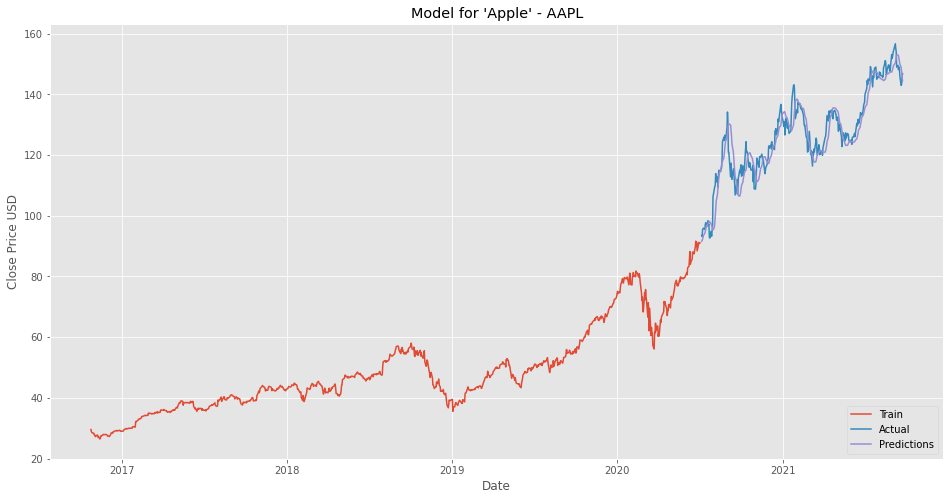

In [40]:
plt.figure(figsize=(16,8))
plt.title(f"Model for '{stock}' - {ticker}")
plt.xlabel("Date")
plt.ylabel("Close Price USD")
plt.plot(train['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# TEST

In [41]:
# for predictions add 100 extra days to make sure it has more than ts_points to make up for missing days (weekends and holidays)

fetch_days = ts_points + 100    

sd =  today - timedelta(days=fetch_days)
sd = sd.strftime('%Y-%m-%d')

ed = today.strftime('%Y-%m-%d')
ed

next_day = (today + timedelta(days=1) ).strftime('%Y-%m-%d')
# next_day

In [42]:
# get the quote
quote = pdr.DataReader(ticker, data_source="yahoo", start=sd, end=ed)
new_df = quote.filter(['Close'])
last_n_days = ts_points
last_n_days_arr = new_df[-last_n_days:].values 

In [43]:
last_n_days_scaled = scaler.transform(last_n_days_arr)
X_test = []
X_test.append(last_n_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))


In [44]:
##########################loading saved model ###############################
new_model = tf.keras.models.load_model('Saved_Models/Model_'+ticker+'.h5')

# Check its architecture
new_model.summary()
nmpred_price = new_model.predict(X_test)
nmpred_price = scaler.inverse_transform(nmpred_price)
nmpred_price = nmpred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {nmpred_price:.4f}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
Predicted Closing price for 'Apple' on 2021-10-25 is 145.7795


In [45]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = pred_price[0][0]
print(f"Predicted Closing price for '{stock}' on {next_day} is {pred_price:.4f}")

Predicted Closing price for 'Apple' on 2021-10-25 is 145.7795


In [46]:
# verify
d1 = today - timedelta(days=5)
d1 = d1.strftime('%Y-%m-%d')

quote2 = pdr.DataReader(ticker, data_source="yahoo", start=d1)
quote2

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-19,149.169998,146.550003,147.009995,148.759995,76378900,148.759995
2021-10-20,149.750000,148.119995,148.699997,149.259995,58418800,149.259995
2021-10-21,149.639999,147.869995,148.809998,149.479996,61421000,149.479996
2021-10-22,150.179993,148.639999,149.690002,148.690002,58839600,148.690002
